In [1]:
from SPC_2L.DataTools import DataBase, to_img, show
import pickle
from SPC_2L.Network import LayerPC, Network
from SPC_2L.Coding import ML_FISTA, ML_Lasso
import torch.nn.functional as f
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid, save_image
import torch
from torchvision.transforms import ToTensor,Compose, Resize
from SPC_2L.DataTools import LCN, whitening, z_score, mask, to_cuda, norm
from torch.utils.data import DataLoader
from torchvision.datasets import STL10
from LogGabor import LogGaborFit

cmap1=plt.get_cmap('tab20c')
cmap2=plt.get_cmap('tab20b')
print(torch.__version__)

1.0.1.post2


In [2]:
def reconstruction(Net,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = Net.layers[j].backward(reco[i])
    return reco
def reconstructionV2(Net,Loss,gamma):
    reco = [None] * (Net.nb_layers)
    for i in range(Net.nb_layers-1,-1,-1):
        reco[i] = gamma[i]
        for j in range(i, -1, -1):
            reco[i] = (Net.layers[j].backward(reco[i])).div(Loss.norm[j])
    return reco

#def PredError(Net,Loss,gamma):
#    reco = [None] * (Net.nb_layers)
#    reco[0] =  Net.layers[0].backward(gamma[0])
#    reco[1] = Net.layersNet.layers[1].backward(gamma[1])
#    return reco


In [3]:
def to_img(x):
    val_max = x.abs().max(-1, keepdim=True)[0].max(-2, keepdim=True)[0].expand_as(x)
    x += val_max
    x /= 2 * val_max
    x.clamp(0, 1)
    return x

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    return plt.show()

In [5]:

## Database 
data_path = '../../DataSet/STL10/'

transform = Compose([ToTensor(),
                    to_cuda(),
                    whitening((96,96),f_0=0.5),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((96,96))])

dataset = STL10(data_path, transform=transform, download=False, split='test')

DataBase = DataLoader(dataset, batch_size=20, shuffle=True, drop_last=True)




In [6]:
DataBase = DataLoader(dataset, batch_size=20, shuffle=True, drop_last=True)

model_name = 'STL_[0.4,1.4]_b=1'
path = 'Savings/STL/' + model_name +'.pkl'
nb_iter_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
#nb_iter_range = [1, 5, 10, 15, 20, 25, 30, 40, 50, 75]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
print(Net.layers[0].b)
Loss = out['Loss']
Pursuit = out['Pursuit'] 
max_batch = 10
all_loss_2LSPC = torch.zeros(len(nb_iter_range),max_batch+1,2)
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(DataBase):
        batch = data[0].cuda()
        if idx_batch>max_batch:
            break
        gamma, it, Loss_G, delta = Pursuit.coding(batch)
        
        reco = reconstruction(Net,gamma)
        error = [(((data[0].cuda() - reco[i]).pow(2).sum())/(data[0].cuda().pow(2).sum())) for i in range(Net.nb_layers)]
        
        for i in range(Net.nb_layers):
            #all_loss_2LSPC[idx_iter,idx_batch,i] = Loss.lambdas[i]*gamma[i].abs().sum().div(batch.size()[0])
            #penalty = [ for i in range(Net.nb_layers)]
            all_loss_2LSPC[idx_iter,idx_batch,i] = Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])
        

1


In [7]:
DataBase = DataLoader(dataset, batch_size=20, shuffle=True, drop_last=True)

model_name = 'STL_[0.4,1.4]_b=0'
path = 'Savings/STL/' + model_name +'.pkl'
#nb_iter_range = [1, 5, 10, 15, 20, 25, 30, 40, 50, 75]
nb_iter_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
print(Net.layers[0].b)
Loss = out['Loss']
Pursuit = out['Pursuit'] 
max_batch = 10
all_loss_HiLa = torch.zeros(len(nb_iter_range),max_batch+1,2)
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(DataBase):
        batch = data[0].cuda()
        if idx_batch>max_batch:
            break
        gamma, it, Loss_G, delta = Pursuit.coding(batch)
        
        reco = reconstruction(Net,gamma)
        error = [(((data[0].cuda() - reco[i]).pow(2).sum())/(data[0].cuda().pow(2).sum())) for i in range(Net.nb_layers)]
        
        for i in range(Net.nb_layers):
            all_loss_HiLa[idx_iter,idx_batch,i] = Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])
            #all_loss_HiLa[idx_iter,idx_batch,i] = Loss.lambdas[i]*gamma[i].abs().sum().div(batch.size()[0])

0


In [8]:
all_loss_mean_2LSPC  = all_loss_2LSPC.mean(dim=1)
all_loss_mean_HiLa  = all_loss_HiLa.mean(dim=1)

print(all_loss_mean_2LSPC[:,0])
print(all_loss_mean_HiLa[:,0])

print(all_loss_mean_2LSPC[:,1])
print(all_loss_mean_HiLa[:,1])

tensor([5935.7168, 2276.0649, 1298.1138,  992.3868,  953.3238,  954.0652,
         891.1667,  899.2656,  898.6582,  843.8858,  864.2826,  871.2181,
         843.4768])
tensor([6329.9146, 2568.3032, 1175.0302,  728.0748,  597.2523,  515.1279,
         507.5388,  469.7997,  471.3166,  440.6646,  428.6867,  440.1115,
         432.9887])
tensor([ 73.6799, 461.3288, 758.2216, 852.5339, 882.0330, 895.4764, 891.1545,
        909.0836, 920.9224, 882.7761, 867.9338, 879.8217, 850.2571])
tensor([  50.8523,  393.3843,  780.8959, 1048.0474, 1183.8053, 1236.9761,
        1273.6202, 1300.7030, 1352.9755, 1372.8954, 1393.4886, 1443.9835,
        1485.5848])


tensor(843.4768)
tensor(432.9887)


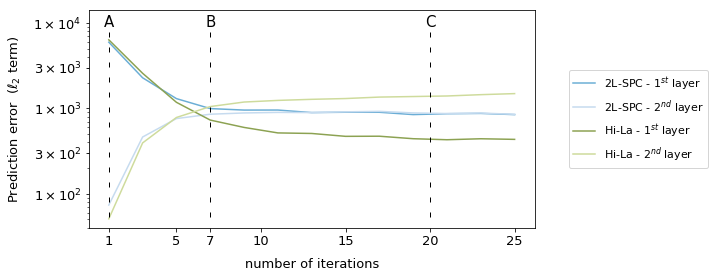

In [10]:
DataBase = DataLoader(dataset, batch_size=20, shuffle=True, drop_last=True)

save_fig = False
fontsize = 13
all_loss_mean_2LSPC  = all_loss_2LSPC.mean(dim=1)
all_loss_mean_HiLa  = all_loss_HiLa.mean(dim=1)

ratio=2
fig1, ax1 = plt.subplots(figsize=(4*ratio,4))


print(all_loss_mean_2LSPC[-1,0])
print(all_loss_mean_HiLa[-1,0])

out_1 = ax1.plot(nb_iter_range, all_loss_mean_2LSPC[:,0].numpy(), color=cmap1(1),label=r'2L-SPC - $1^{st}$ layer')
out_2 = ax1.plot(nb_iter_range, all_loss_mean_2LSPC[:,1].numpy(), color=cmap1(3),label=r'2L-SPC - $2^{nd}$ layer')
out_3 = ax1.plot(nb_iter_range, all_loss_mean_HiLa[:,0].numpy(), color=cmap2(5),label=r'Hi-La - $1^{st}$ layer')
out_4 = ax1.plot(nb_iter_range, all_loss_mean_HiLa[:,1].numpy(), color=cmap2(7),label=r'Hi-La - $2^{nd}$ layer')


#circle = plt.Circle((1,12000), radius=1000)

#ax1.add_patch(circle)

ax1.text(0.7,9000,'A',fontsize=15)
ax1.axvline(1, ymin=0.05 ,ymax=0.90, color='black',linestyle='--',linewidth=1, dashes=(5, 10))
ax1.text(6.7,9000,'B',fontsize=15)
ax1.axvline(7, ymin=0.05 ,ymax=0.90, color='black',linestyle='--',linewidth=1, dashes=(5, 10))
ax1.text(19.7,9000,'C',fontsize=15)
ax1.axvline(20, ymin=0.05 ,ymax=0.90, color='black',linestyle='--',linewidth=1, dashes=(5, 10))
#ax1.Circle((1,12000),radius=1000)
#ax1.set_xticks([0,25,50,75])
#ax1.set_xticklabels([0,25,50,75],fontsize=15)
ax1.set_xticks([1,5,7,10,15,20,25])
ax1.set_xticklabels([1,5,7,10,15,20,25],fontsize=fontsize)

ax1.set_yscale('log')

ax1.set_yticks([100,300,1000,3000,10000])
ax1.set_yticklabels([r'$1\times10^2$',r'$3\times10^2$',r'$1\times10^3$', r'$3\times10^3$', r'$1\times10^4$'],fontsize=fontsize)

out = ax1.set_xlabel("number of iterations", fontsize=fontsize, labelpad=10)
out = ax1.set_ylabel("Prediction error " + r' ($\ell_2$ term)', fontsize=fontsize, labelpad=10)

ax1.set_ylim(0,14000)

#ax1.legend((out_1, out_2, out_3, out_4), 
#          ('Layer SDPC', 'Layer1 SDPC','Layer0 HiLa', 'Layer1 HiLa'),
#          ncol=1, bbox_to_anchor=(1, 7)#, loc='center left')
ax1.legend(ncol=1, bbox_to_anchor=(1.4, 0.5), loc='center right',fontsize=11)
#ax1.legend(fontsize=11)
fig1.show()
           
if save_fig:
    plt.savefig('Savings/Fig/Fig5/PredictionError.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
    #plt.savefig('Savings/Fig/Fig5/PredictionError_legend.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
#ax1.set_xscale('log')

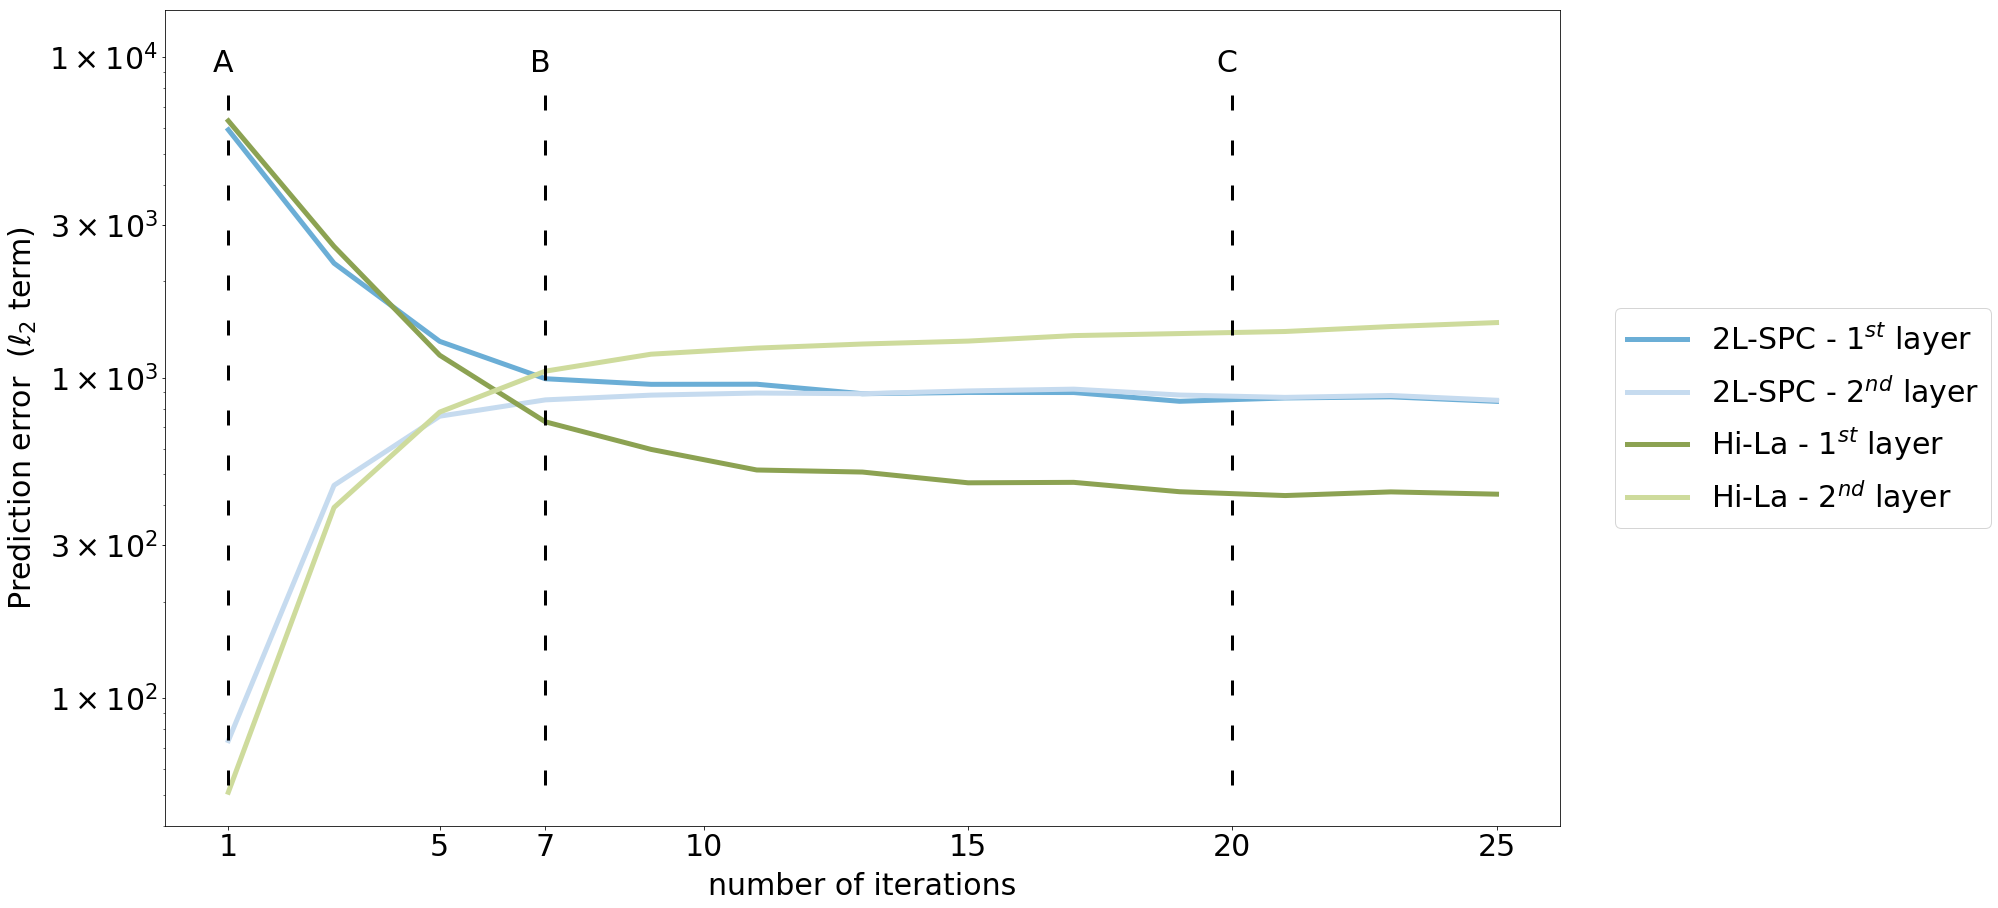

In [23]:
## Generate a nice figure for the github markdown

DataBase = DataLoader(dataset, batch_size=20, shuffle=True, drop_last=True)

save_fig = True
fontsize = 30
all_loss_mean_2LSPC  = all_loss_2LSPC.mean(dim=1)
all_loss_mean_HiLa  = all_loss_HiLa.mean(dim=1)

#ratio=2
#fig1, ax1 = plt.subplots(figsize=(4*ratio,4))
fig1, ax1 = plt.subplots(figsize=(25,15))

out_1 = ax1.plot(nb_iter_range, all_loss_mean_2LSPC[:,0].numpy(), color=cmap1(1),linewidth=5, label=r'2L-SPC - $1^{st}$ layer')
out_2 = ax1.plot(nb_iter_range, all_loss_mean_2LSPC[:,1].numpy(), color=cmap1(3),linewidth=5,label=r'2L-SPC - $2^{nd}$ layer')
out_3 = ax1.plot(nb_iter_range, all_loss_mean_HiLa[:,0].numpy(), color=cmap2(5),linewidth=5,label=r'Hi-La - $1^{st}$ layer')
out_4 = ax1.plot(nb_iter_range, all_loss_mean_HiLa[:,1].numpy(), color=cmap2(7),linewidth=5,label=r'Hi-La - $2^{nd}$ layer')


#circle = plt.Circle((1,12000), radius=1000)

#ax1.add_patch(circle)

ax1.text(0.7,9000,'A',fontsize=fontsize)
ax1.axvline(1, ymin=0.05 ,ymax=0.90, color='black',linestyle='--',linewidth=3, dashes=(5, 10))
ax1.text(6.7,9000,'B',fontsize=fontsize)
ax1.axvline(7, ymin=0.05 ,ymax=0.90, color='black',linestyle='--',linewidth=3, dashes=(5, 10))
ax1.text(19.7,9000,'C',fontsize=fontsize)
ax1.axvline(20, ymin=0.05 ,ymax=0.90, color='black',linestyle='--',linewidth=3, dashes=(5, 10))
#ax1.Circle((1,12000),radius=1000)
#ax1.set_xticks([0,25,50,75])
#ax1.set_xticklabels([0,25,50,75],fontsize=15)
ax1.set_xticks([1,5,7,10,15,20,25])
ax1.set_xticklabels([1,5,7,10,15,20,25],fontsize=fontsize)

ax1.set_yscale('log')

ax1.set_yticks([100,300,1000,3000,10000])
ax1.set_yticklabels([r'$1\times10^2$',r'$3\times10^2$',r'$1\times10^3$', r'$3\times10^3$', r'$1\times10^4$'],fontsize=fontsize)

out = ax1.set_xlabel("number of iterations", fontsize=fontsize, labelpad=10)
out = ax1.set_ylabel("Prediction error " + r' ($\ell_2$ term)', fontsize=fontsize, labelpad=10)

ax1.set_ylim(0,14000)

#ax1.legend((out_1, out_2, out_3, out_4), 
#          ('Layer SDPC', 'Layer1 SDPC','Layer0 HiLa', 'Layer1 HiLa'),
#          ncol=1, bbox_to_anchor=(1, 7)#, loc='center left')
ax1.legend(ncol=1, bbox_to_anchor=(1.32, 0.5), loc='center right',fontsize=fontsize)
#ax1.legend(fontsize=11)
fig1.show()
           
if save_fig:
    #plt.savefig('Savings/Fig/Fig5/PredictionError.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
    #plt.savefig('Savings/Fig/Fig5/PredictionError_legend.pdf', bbox_inches = 'tight', pad_inches = 0.1, format='pdf')
    plt.savefig('Savings/Fig/Fig5-a.png', bbox_inches = 'tight', pad_inches = 0.1)
#ax1.set_xscale('log')

In [10]:
batch_size=40
transform = Compose([Resize((120,120)),
                    ToTensor(),
                    to_cuda(),
                    whitening((120,120),f_0=0.8,n=3),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((120,120))])
                     

dataset = STL10(data_path, transform=transform, download=False, split='train')

DataBase = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

model_name = 'STL_[0.4,1.4]_b=1'
path = 'Savings/STL/' + model_name +'.pkl'
nb_iter_range = [1, 5, 7, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 175]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
print(Net.layers[0].b)
Loss = out['Loss']
Pursuit = out['Pursuit'] 
max_batch = 1
all_reco_2LSPC = torch.zeros(len(nb_iter_range),2,40,3,120,120).cuda()
all_error_2LSPC = torch.zeros(len(nb_iter_range),2,40,3,120,120).cuda()
#pred_error_2LSPC_Layer2 = torch.zeros(len(nb_iter_range),40,3,120,120)
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(DataBase):
        batch = data[0].cuda()
        if idx_batch == 29:
            
            gamma, it, Loss_G, delta = Pursuit.coding(batch)

            reco = reconstruction(Net,gamma)
            
            for i in range(Net.nb_layers):
                maxi, _ = reco[i].view(40,-1).max(dim=1)
                maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
                reco[i] = reco[i]/maxi
                all_reco_2LSPC[idx_iter,i,:,:,:,:]=reco[i]
                
            
            
            maxi, _ = batch.view(40,-1).max(dim=1)
            maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            batch = batch/maxi
            all_error_2LSPC[idx_iter,0,:,:,:,:] = batch - all_reco_2LSPC[idx_iter,0,:,:,:,:]
            all_error_2LSPC[idx_iter,1,:,:,:,:] = all_reco_2LSPC[idx_iter,0,:,:,:,:] - all_reco_2LSPC[idx_iter,1,:,:,:,:]
            

                
            #error = gamma[0]- Net.layers[1].backward(gamma[1])
            #pred_error_2LSPC_Layer2[idx_iter,:,:,:,:] = Net.layers[0].backward(error)


1


In [11]:
batch_size=40
transform = Compose([Resize((120,120)),
                    ToTensor(),
                    to_cuda(),
                    whitening((120,120),f_0=0.8,n=3),
                    LCN(kernel_size=9,sigma=0.5,rgb=True),
                    z_score(),
                    mask((120,120))])
                     

dataset = STL10(data_path, transform=transform, download=False, split='train')

DataBase = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)

model_name = 'STL_[0.4,1.4]_b=0'
path = 'Savings/STL/' + model_name +'.pkl'
nb_iter_range = [1, 5,7, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 175]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
Loss = out['Loss']
Pursuit = out['Pursuit'] 
print(Net.layers[0].b)
max_batch = 1
all_reco_HiLa = torch.zeros(len(nb_iter_range),2,40,3,120,120).cuda()
all_error_HiLa = torch.zeros(len(nb_iter_range),2,40,3,120,120).cuda()
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(DataBase):
        batch = data[0].cuda()
        if idx_batch == 29:
            
            gamma, it, Loss_G, delta = Pursuit.coding(batch)
            reco = reconstruction(Net,gamma)
            
            #for i in range(Net.nb_layers):
            #    all_reco_HiLa[idx_iter,i,:,:,:,:]=reco[i]
            #error = gamma[0]- Net.layers[1].backward(gamma[1])
            #pred_error_HiLa_Layer2[idx_iter,:,:,:,:] = Net.layers[0].backward(error)
            for i in range(Net.nb_layers):
                maxi, _ = reco[i].view(40,-1).max(dim=1)
                maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
                reco[i] = reco[i]/maxi
                all_reco_HiLa[idx_iter,i,:,:,:,:]=reco[i]
            
            maxi, _ = batch.view(40,-1).max(dim=1)
            maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            batch = batch/maxi
            all_error_HiLa[idx_iter,0,:,:,:,:] = batch - all_reco_HiLa[idx_iter,0,:,:,:,:]
            all_error_HiLa[idx_iter,1,:,:,:,:] = all_reco_HiLa[idx_iter,0,:,:,:,:] - all_reco_HiLa[idx_iter,1,:,:,:,:]

0


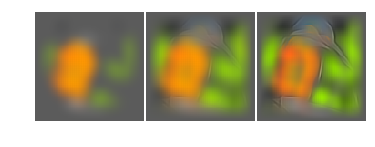

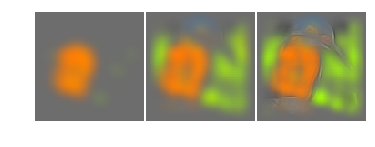

In [14]:
save_fig = True
#to_plot = [0,1,2,3,4,5]
to_plot = [0,2,5]

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}
#8
idx_image = 37

img = make_grid(all_reco_2LSPC[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_2LSPC_STL_L2.pdf')
    
img = make_grid(all_reco_HiLa[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_HiLa_STL_L2.pdf')

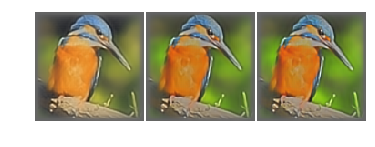

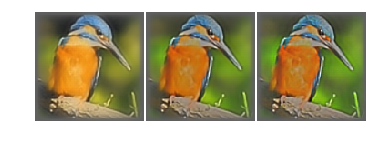

In [15]:
save_fig = True
#to_plot = [0,1,2,3,4,5]
to_plot = [0,2,5]
grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}
#8
idx_image = 37

img = make_grid(all_reco_2LSPC[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_2LSPC_STL_L1.pdf')
    
img = make_grid(all_reco_HiLa[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_HiLa_STL_L1.pdf')

In [16]:
## plotting error

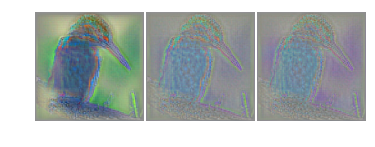

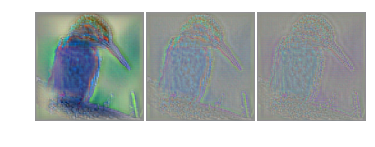

In [17]:
save_fig = False
#to_plot = [0,1,2,3,4,5]
to_plot = [0,2,5]
grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}
#8
idx_image = 37

img = make_grid(all_error_2LSPC[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_2LSPC_STL_L1.png')
    
img = make_grid(all_error_HiLa[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_HiLa_STL_L1.png')

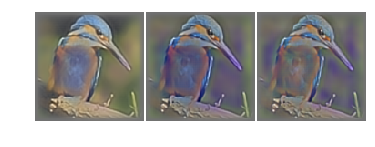

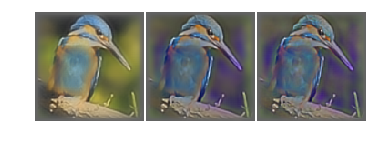

tensor(31480, device='cuda:0')
tensor(11720, device='cuda:0')
torch.Size([3, 122, 364])


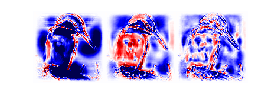

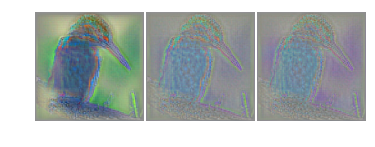

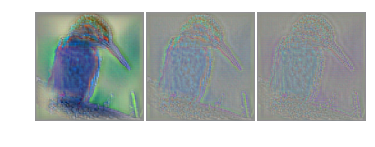

tensor(14435, device='cuda:0')
tensor(28765, device='cuda:0')


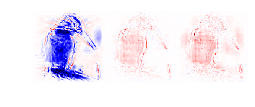

In [26]:
save_fig = False
#to_plot = [0,1,2,3,4,5]
to_plot = [0,2,5]
grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}
#37
#
idx_image = 37

img = make_grid(all_error_2LSPC[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
#if save_fig == True:
#    save_image(img,'Savings/Fig/Fig5/Error_2LSPC_STL_L2.png')
    
img = make_grid(all_error_HiLa[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
#if save_fig == True:
#    save_image(img,'Savings/Fig/Fig5/Error_HiLa_STL_L2.png')
    

to_pl = all_error_HiLa[to_plot,1,idx_image,:,:,:].pow(2) - all_error_2LSPC[to_plot,1,idx_image,:,:,:].pow(2)

to_pl = to_pl.mean(dim=1)
to_pl = to_pl.unsqueeze(1)


grid_param = {'padding':1, 'normalize':False, 
                            'pad_value':0, 
                            'nrow':len(to_plot), 'scale_each':False}

print((to_pl[:,:,:,:]>0).sum())
print((to_pl[:,:,:,:]<0).sum())
img = make_grid(to_pl,**grid_param)
print(img.size())

ratio = 3

#fig1, ax1 = plt.subplots()


fig1 = plt.figure()
fig1.set_size_inches(img.size(-1)/img.size(-2), 1, forward=False)
    
ax1 = plt.Axes(fig1, [0., 0., 1., 1.])
ax1.set_axis_off()
fig1.add_axes(ax1)

img_matplot = img[0,:,:]

npimg = img_matplot.cpu().numpy()

out = ax1.imshow(npimg, interpolation='nearest',cmap='seismic_r',vmin=-0.05,vmax=0.05)


#fig1.add_axes(ax1)
#cb = fig1.colorbar(out, ax=ax1, extend='both',location='bottom',ticks=[-0.05,0,0.05])
#cb.ax.set_xticklabels(labels=[r'$-5\cdot10^{-2}$' + ' (Hi-La)','0',r'$5\cdot10^{-2}$' + ' (2L-SPC)'] ,fontsize=20)

#cb.set_label(r'$\delta_{L2}$',fontsize=20, labelpad=10)


    
if save_fig == True:
    plt.savefig('Savings/Fig/Fig5/DiffError_Layer2.pdf', dpi=img.size(-2),format='pdf')
    #plt.savefig('Savings/Fig/Fig5/DiffError_Layer2_legend.png',  bbox_inches='tight', pad_inches = 0)
plt.show()

## First Layer

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}



img = make_grid(all_error_2LSPC[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())

    
img = make_grid(all_error_HiLa[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
#if save_fig == True:
#    save_image(img,'Savings/Fig/Fig5/Error_HiLa_STL_L1.png')
    

to_pl = all_error_HiLa[to_plot,0,idx_image,:,:,:].pow(2) - all_error_2LSPC[to_plot,0,idx_image,:,:,:].pow(2)

to_pl = to_pl.mean(dim=1)
to_pl = to_pl.unsqueeze(1)


grid_param = {'padding':1, 'normalize':False, 
                            'pad_value':0, 
                            'nrow':len(to_plot), 'scale_each':False}

print((to_pl[:,:,:,:]>0).sum())
print((to_pl[:,:,:,:]<0).sum())

img = make_grid(to_pl,**grid_param)

fig1 = plt.figure()
fig1.set_size_inches(img.size(-1)/img.size(-2), 1, forward=False)
    
ax1 = plt.Axes(fig1, [0., 0., 1., 1.])
ax1.set_axis_off()
fig1.add_axes(ax1)

img_matplot = img[0,:,:]

npimg = img_matplot.cpu().numpy()
#plt.imshow(np.transpose(npimg, (0,1)), interpolation='nearest',cmap='seismic')
out = ax1.imshow(npimg, interpolation='nearest',cmap='seismic_r',vmin=-0.05,vmax=0.05)
#fig1.add_axes(ax1)
#cb = fig1.colorbar(out, ax=ax1, extend='both',location='bottom',ticks=[-0.05,0,0.05])
#cb.ax.set_xticklabels(labels=[r'$-5\cdot10^{-2}$' + ' (Hi-La)','0',r'$5\cdot10^{-2}$' + ' (2L-SPC)'] ,fontsize=20)
#cb.set_label(r'$\delta_{L1}$' + ' and ' + r'$\delta_{L2}$',fontsize=20, labelpad=10)
plt.tight_layout()
#plt.axis('off')
if save_fig == True:
    plt.savefig('Savings/Fig/Fig5/DiffError_Layer1.pdf', dpi=img.size(-2), format='pdf')
    #plt.savefig('Savings/Fig/Fig5/DiffError_Layer1_legend.pdf', bbox_inches='tight', pad_inches = 0, format='pdf')
plt.show()






In [541]:
## Same experiment on CFD

In [511]:
from  SPC_2L.DataTools import DataBase
data_path = '../DataSet/CF_DB_training'

LCN_params = {'kernel_size':11,'sigma':0.5, 'rgb':True} # Local contrast normalization parameters

mask_params={'n': 10} # mask parameters

whitening_params={'f_0':0.5,'n':2} # Whitening parameters

Data_load_param = { 'batch_size': 10,
                    'do_LCN': True,
                    'LCN_params': LCN_params,
                    'do_mask': True,
                    'mask_params': mask_params,
                    'do_whitening': True,
                    'whitening_params': whitening_params,
                    'do_z_score': True,
                    'return_idx': False
                  }

Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=True)





In [512]:
Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=True)

model_name = 'CFD_[0.3,1.0]_b=1'
path = 'Savings/CFD/' + model_name +'.pkl'
nb_iter_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
#nb_iter_range = [1, 5, 10, 15, 20, 25, 30, 40, 50, 75]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
print(Net.layers[0].b)
Loss = out['Loss']
Pursuit = out['Pursuit'] 
max_batch = 10
all_loss_2LSPC = torch.zeros(len(nb_iter_range),max_batch+1,2)
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        if idx_batch>max_batch:
            break
        gamma, it, Loss_G, delta = Pursuit.coding(batch)
        
        reco = reconstruction(Net,gamma)
        error = [(((data[0].cuda() - reco[i]).pow(2).sum())/(data[0].cuda().pow(2).sum())) for i in range(Net.nb_layers)]
        
        for i in range(Net.nb_layers):
            #all_loss_2LSPC[idx_iter,idx_batch,i] = Loss.lambdas[i]*gamma[i].abs().sum().div(batch.size()[0])
            #penalty = [ for i in range(Net.nb_layers)]
            all_loss_2LSPC[idx_iter,idx_batch,i] = Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])
        

1


In [513]:
Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=True)

model_name = 'CFD_[0.3,1.0]_b=0'
path = 'Savings/CFD/' + model_name +'.pkl'
#nb_iter_range = [1, 5, 10, 15, 20, 25, 30, 40, 50, 75]
nb_iter_range = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
print(Net.layers[0].b)
Loss = out['Loss']
Pursuit = out['Pursuit'] 
max_batch = 10
all_loss_HiLa = torch.zeros(len(nb_iter_range),max_batch+1,2)
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        if idx_batch>max_batch:
            break
        gamma, it, Loss_G, delta = Pursuit.coding(batch)
        
        reco = reconstruction(Net,gamma)
        error = [(((data[0].cuda() - reco[i]).pow(2).sum())/(data[0].cuda().pow(2).sum())) for i in range(Net.nb_layers)]
        
        for i in range(Net.nb_layers):
            all_loss_HiLa[idx_iter,idx_batch,i] = Loss.F(batch,gamma,i, do_feedback=False).div(batch.size()[0])
            #all_loss_HiLa[idx_iter,idx_batch,i] = Loss.lambdas[i]*gamma[i].abs().sum().div(batch.size()[0])

0


tensor(335.4239)
tensor(335.3451)


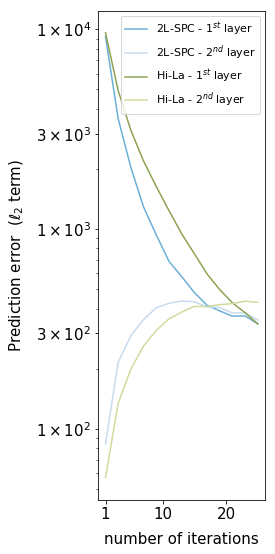

In [514]:


save_fig = False
all_loss_mean_2LSPC  = all_loss_2LSPC.mean(dim=1)
all_loss_mean_HiLa  = all_loss_HiLa.mean(dim=1)

ratio=3
fig1, ax1 = plt.subplots(figsize=(3,3*ratio))


print(all_loss_mean_2LSPC[-1,0])
print(all_loss_mean_HiLa[-1,0])

out_1 = ax1.plot(nb_iter_range, all_loss_mean_2LSPC[:,0].numpy(), color=cmap1(1),label=r'2L-SPC - $1^{st}$ layer')
out_2 = ax1.plot(nb_iter_range, all_loss_mean_2LSPC[:,1].numpy(), color=cmap1(3),label=r'2L-SPC - $2^{nd}$ layer')
out_3 = ax1.plot(nb_iter_range, all_loss_mean_HiLa[:,0].numpy(), color=cmap2(5),label=r'Hi-La - $1^{st}$ layer')
out_4 = ax1.plot(nb_iter_range, all_loss_mean_HiLa[:,1].numpy(), color=cmap2(7),label=r'Hi-La - $2^{nd}$ layer')

#ax1.set_xticks([0,25,50,75])
#ax1.set_xticklabels([0,25,50,75],fontsize=15)
ax1.set_xticks([1,10,20])
ax1.set_xticklabels([1,10,20],fontsize=15)

ax1.set_yscale('log')

ax1.set_yticks([100,300,1000,3000,10000])
ax1.set_yticklabels([r'$1\times10^2$',r'$3\times10^2$',r'$1\times10^3$', r'$3\times10^3$', r'$1\times10^4$'],fontsize=15)

out = ax1.set_xlabel("number of iterations", fontsize=15, labelpad=10)
out = ax1.set_ylabel("Prediction error " + r' ($\ell_2$ term)', fontsize=15, labelpad=10)


#ax1.legend((out_1, out_2, out_3, out_4), 
#          ('Layer SDPC', 'Layer1 SDPC','Layer0 HiLa', 'Layer1 HiLa'),
#          ncol=1, bbox_to_anchor=(1, 0.5), loc='center left')
#ax1.legend(ncol=1, bbox_to_anchor=(1, 0.5), loc='center left')
ax1.legend(fontsize=11)
fig1.show()
           
if save_fig:
    plt.savefig('Savings/Fig/Fig5/PredictionError.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
     #plt.savefig('Savings/Fig/Fig5/PredictionError_legend.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=400)
#ax1.set_xscale('log')

In [515]:
Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=False)

model_name = 'CFD_[0.3,1.0]_b=1'
path = 'Savings/CFD/' + model_name +'.pkl'
nb_iter_range = [1, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 175]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
print(Net.layers[0].b)
Loss = out['Loss']
Pursuit = out['Pursuit'] 
max_batch = 1
all_reco_2LSPC = torch.zeros(len(nb_iter_range),2,10,3,120,171).cuda()
all_error_2LSPC = torch.zeros(len(nb_iter_range),2,10,3,120,171).cuda()
#pred_error_2LSPC_Layer2 = torch.zeros(len(nb_iter_range),40,3,120,120)
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        if idx_batch == 29:
            
            gamma, it, Loss_G, delta = Pursuit.coding(batch)

            reco = reconstruction(Net,gamma)
            
            for i in range(Net.nb_layers):
                maxi, _ = reco[i].view(10,-1).max(dim=1)
                maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
                reco[i] = reco[i]/maxi
                all_reco_2LSPC[idx_iter,i,:,:,:,:]=reco[i]
            
            maxi, _ = batch.view(10,-1).max(dim=1)
            maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            batch = batch/maxi
            for i in range(Net.nb_layers):
                all_error_2LSPC[idx_iter,i,:,:,:,:] = batch - all_reco_2LSPC[idx_iter,i,:,:,:,:]
            #error = gamma[0]- Net.layers[1].backward(gamma[1])
            #pred_error_2LSPC_Layer2[idx_iter,:,:,:,:] = Net.layers[0].backward(error)



1


In [516]:
Facedata = DataBase('from_ImageFolder', data_path, img_size=(100,124),reshaped_size=(120,171),**Data_load_param, shuffle=False)
model_name = 'CFD_[0.3,1.0]_b=0'
path = 'Savings/CFD/' + model_name +'.pkl'
nb_iter_range = [1, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 125, 150, 175]
with open(path, 'rb') as file:
    out = pickle.load(file)
Net = out['Net']
Loss = out['Loss']
Pursuit = out['Pursuit'] 
print(Net.layers[0].b)
max_batch = 1
all_reco_HiLa = torch.zeros(len(nb_iter_range),2,10,3,120,171).cuda()
all_error_HiLa = torch.zeros(len(nb_iter_range),2,10,3,120,171).cuda()
for idx_iter, nb_iter in enumerate(nb_iter_range) : 
    Pursuit.max_iter = nb_iter
    for idx_batch, data in enumerate(Facedata.data):
        batch = data[0].cuda()
        if idx_batch == 29:
            
            gamma, it, Loss_G, delta = Pursuit.coding(batch)
            reco = reconstruction(Net,gamma)
            
            #for i in range(Net.nb_layers):
            #    all_reco_HiLa[idx_iter,i,:,:,:,:]=reco[i]
            #error = gamma[0]- Net.layers[1].backward(gamma[1])
            #pred_error_HiLa_Layer2[idx_iter,:,:,:,:] = Net.layers[0].backward(error)
            for i in range(Net.nb_layers):
                maxi, _ = reco[i].view(10,-1).max(dim=1)
                maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
                reco[i] = reco[i]/maxi
                all_reco_HiLa[idx_iter,i,:,:,:,:]=reco[i]
            
            maxi, _ = batch.view(10,-1).max(dim=1)
            maxi = maxi.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            batch = batch/maxi
            for i in range(Net.nb_layers):
                all_error_HiLa[idx_iter,i,:,:,:,:] = batch - all_reco_HiLa[idx_iter,i,:,:,:,:]

0


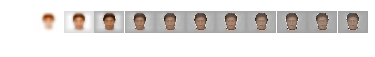

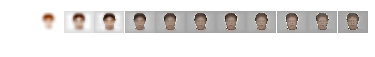

In [517]:
save_fig = False
to_plot = [0,1,2,3,4,5,6,7,8,9,10]

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot),
                         'scale_each':True}
#8
idx_image = 4

img = make_grid(all_reco_2LSPC[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_2LSPC_STL_L2.png')
    
img = make_grid(all_reco_HiLa[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_HiLa_STL_L2.png')

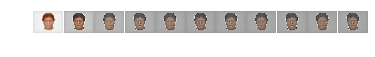

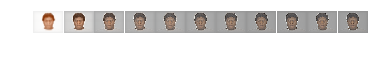

In [518]:
save_fig = False
to_plot = [0,1,2,3,4,5,6,7,8,9,10]

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot),
                         'scale_each':True}
#8
idx_image = 4

img = make_grid(all_reco_2LSPC[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_2LSPC_STL_L1.png')
    
img = make_grid(all_reco_HiLa[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Reco_HiLa_STL_L1.png')

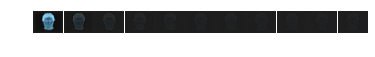

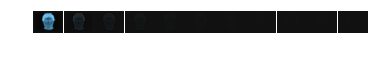

In [519]:
save_fig = False
to_plot = [0,1,2,3,4,5,6,7,8,9,10]
grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}
#8
idx_image = 4

img = make_grid(all_error_2LSPC[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_2LSPC_STL_L1.png')
    
img = make_grid(all_error_HiLa[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_HiLa_STL_L1.png')

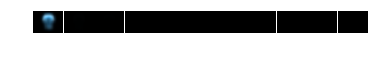

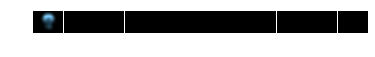

tensor(118978, device='cuda:0')
tensor(105562, device='cuda:0')


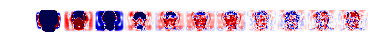

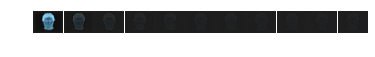

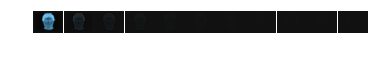

tensor(122765, device='cuda:0')
tensor(102955, device='cuda:0')


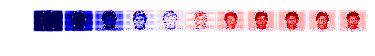

In [520]:
save_fig = False
to_plot = [0,1,2,3,4,5,6,7,8,9,10]
grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}
#8
idx_image = 4

img = make_grid(all_error_2LSPC[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_2LSPC_STL_L2.png')
    
img = make_grid(all_error_HiLa[to_plot,1,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_HiLa_STL_L2.png')
    

to_pl = all_error_2LSPC[to_plot,1,idx_image,:,:,:].abs() - all_error_HiLa[to_plot,1,idx_image,:,:,:].abs()

to_pl = to_pl.mean(dim=1)
to_pl = to_pl.unsqueeze(1)


grid_param = {'padding':1, 'normalize':False, 
                            'pad_value':0, 
                            'nrow':12, 'scale_each':False}

print((to_pl[:,:,:,:]>0).sum())
print((to_pl[:,:,:,:]<0).sum())

img = make_grid(to_pl,**grid_param)

img_matplot = img[0,:,:]

npimg = img_matplot.cpu().numpy()
#plt.imshow(np.transpose(npimg, (0,1)), interpolation='nearest',cmap='seismic')
plt.imshow(npimg, interpolation='nearest',cmap='seismic',vmin=-0.15,vmax=0.15)
plt.axis('off')
plt.show()

## First Layer

grid_param = {'padding':2, 'normalize':True, 
                        'pad_value':1, 
                        'nrow':len(to_plot)}

idx_image = 4

img = make_grid(all_error_2LSPC[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_2LSPC_STL_L1.png')
    
img = make_grid(all_error_HiLa[to_plot,0,idx_image,:,:,:],**grid_param)

plot_L2 = show(img.cpu())
if save_fig == True:
    save_image(img,'Savings/Fig/Fig5/Error_HiLa_STL_L1.png')
    

to_pl = all_error_2LSPC[to_plot,0,idx_image,:,:,:].abs() - all_error_HiLa[to_plot,0,idx_image,:,:,:].abs()

to_pl = to_pl.mean(dim=1)
to_pl = to_pl.unsqueeze(1)


grid_param = {'padding':1, 'normalize':False, 
                            'pad_value':0, 
                            'nrow':12, 'scale_each':False}

print((to_pl[:,:,:,:]>0).sum())
print((to_pl[:,:,:,:]<0).sum())

img = make_grid(to_pl,**grid_param)

img_matplot = img[0,:,:]

npimg = img_matplot.cpu().numpy()
#plt.imshow(np.transpose(npimg, (0,1)), interpolation='nearest',cmap='seismic')
plt.imshow(npimg, interpolation='nearest',cmap='seismic',vmin=-0.1,vmax=0.1)
plt.axis('off')
plt.show()





